**Leveraging Explainable AI to Identify Determinants of Lifetime HIV Testing in Tennessee Adults: Evidence for Targeted Public Health Strategies from BRFSS 2023**

This is a machine learning project that is aimed at predicting self-reported Lifetime HIV Testing among adults in the state of Tennessee, United States of America (USA), using the Behavioral Risk Factor Surveillance System (BRFSS) 2023 data.

Load packages needed for the analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import shap
from google.colab import files

Load the dataset

In [2]:
uploaded = files.upload()

Saving EverHIV_cleaned_MLready.dta to EverHIV_cleaned_MLready.dta


**Importing the dataset and take a look at it**

In [3]:
# import Stata dataset
dhs18 = pd.read_stata('EverHIV_cleaned_MLready.dta', convert_categoricals=False)

In [4]:
# Take a look at the dataset
dhs18.shape

(4911, 25)

In [5]:
# Drop one of the variables in the analysis
dhs18 = dhs18.drop(columns=['_psu', '_ststr', '_llcpwt'])


In [6]:
dhs18.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4911 entries, 0 to 4910
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   good_health                      4911 non-null   int8   
 1   phys_health_days                 4911 non-null   int8   
 2   ment_health_days                 4911 non-null   int8   
 3   health_insurance                 4911 non-null   int8   
 4   phys_activity                    4911 non-null   int8   
 5   race_ethnicity                   4911 non-null   int8   
 6   sex                              4911 non-null   int8   
 7   age_group                        4911 non-null   int8   
 8   bmi_category                     4911 non-null   int8   
 9   education_level                  4911 non-null   int8   
 10  income_group                     4911 non-null   int8   
 11  smoking_status                   4911 non-null   int8   
 12  alcohol_use         

In [7]:
dhs18.columns

Index(['good_health', 'phys_health_days', 'ment_health_days',
       'health_insurance', 'phys_activity', 'race_ethnicity', 'sex',
       'age_group', 'bmi_category', 'education_level', 'income_group',
       'smoking_status', 'alcohol_use', 'veteran_status', 'urban_rural',
       'health_affordability_difficulty', 'recent_checkup', 'comorbidity_cat',
       'marital_status', 'employment_status', 'ever_test_for_HIV',
       'disabilities_count'],
      dtype='object')

In [8]:
# Defining the X variables
x = dhs18 [['good_health', 'phys_health_days', 'ment_health_days',
       'health_insurance', 'phys_activity', 'race_ethnicity', 'sex',
       'age_group', 'bmi_category', 'education_level', 'income_group',
       'smoking_status', 'alcohol_use', 'veteran_status', 'urban_rural',
       'health_affordability_difficulty', 'recent_checkup', 'comorbidity_cat',
       'marital_status', 'employment_status','disabilities_count']]

In [9]:
# Take a look at the X variables
x.shape

(4911, 21)

In [10]:
# Checking for missing values
x.isnull().sum()

,0
good_health,0
phys_health_days,0
ment_health_days,0
health_insurance,0
phys_activity,0
race_ethnicity,0
sex,0
age_group,0
bmi_category,0
education_level,0


In [11]:
# Defining the Y variable in the analysis
y = dhs18.ever_test_for_HIV

In [12]:
# Take a look at the Y variable
y.shape

(4911,)

In [13]:
y.value_counts()

,count
ever_test_for_HIV,
0.0,3155
1.0,1756


In [14]:
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 4911 entries, 0 to 4910
Series name: ever_test_for_HIV
Non-Null Count  Dtype  
--------------  -----  
4911 non-null   float32
dtypes: float32(1)
memory usage: 19.3 KB


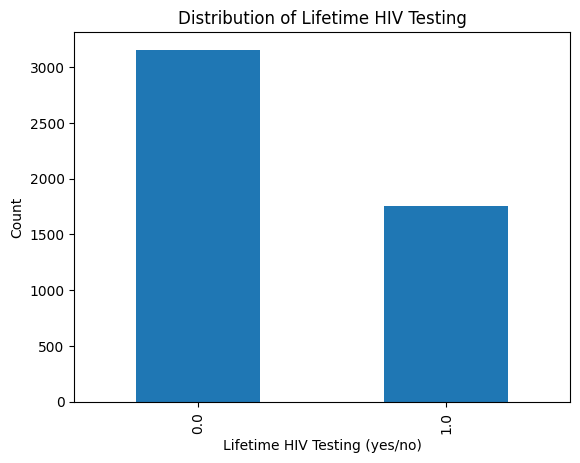

In [15]:
# prompt: plot a plot for the y.value_counts
y.value_counts().plot(kind='bar')
plt.title('Distribution of Lifetime HIV Testing')
plt.xlabel('Lifetime HIV Testing (yes/no)')
plt.ylabel('Count')
plt.show()

**Checking for Multicollinearity between the variables**

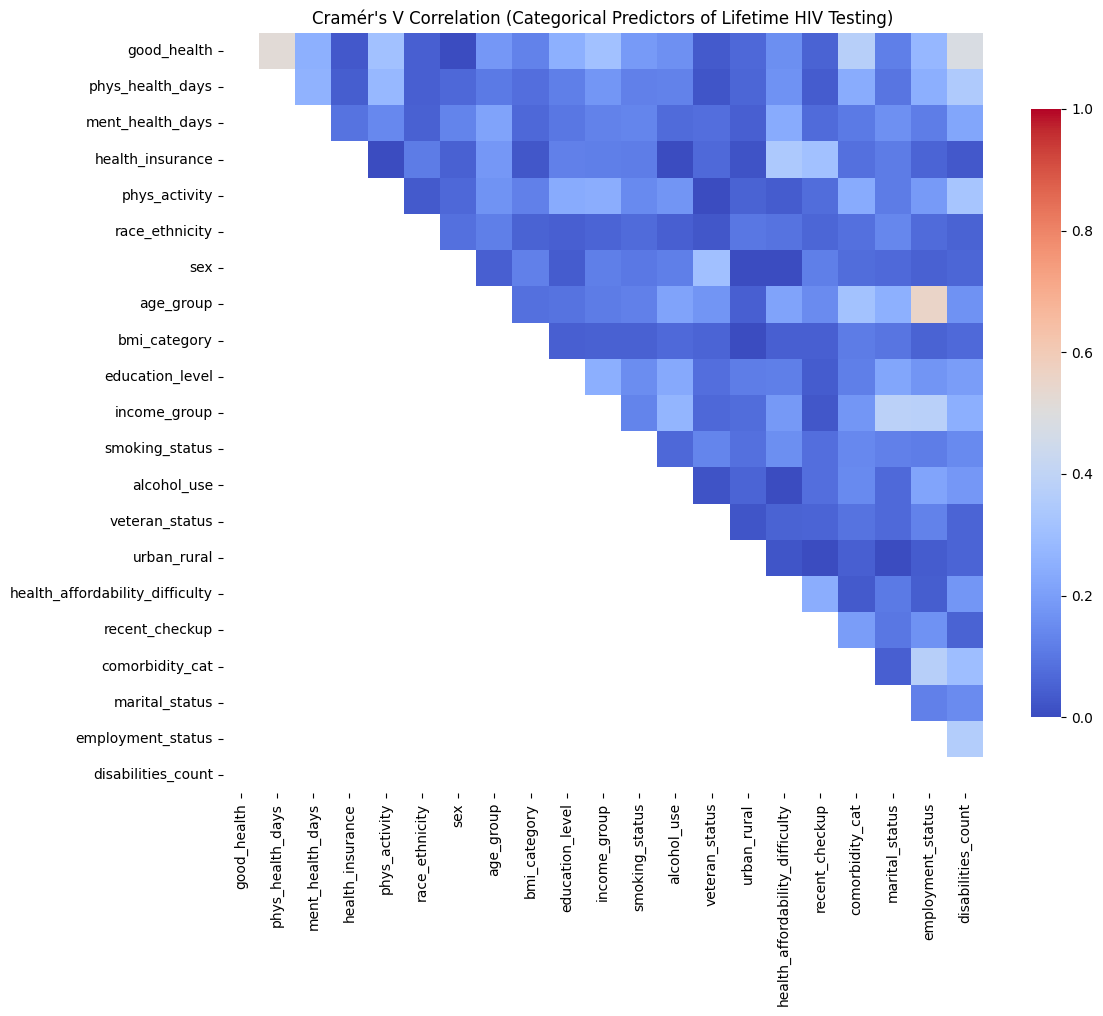


Pairs with Cramér's V ≥ 0.7 (possible redundancy):
  None at or above threshold.


In [16]:
# ==== Multicollinearity among categorical predictors via Cramér's V ====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

# 1) Cramér's V (bias-corrected) for two categorical Series
def cramers_v(x: pd.Series, y: pd.Series) -> float:
    tbl = pd.crosstab(x, y, dropna=False)
    # Need at least 2x2 table with variation
    if tbl.shape[0] < 2 or tbl.shape[1] < 2:
        return 0.0
    chi2 = chi2_contingency(tbl, correction=False)[0]
    n = tbl.values.sum()
    if n == 0:
        return 0.0
    phi2 = chi2 / n
    r, k = tbl.shape
    # Bias correction (Bergsma 2013)
    phi2corr = max(0.0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    denom = min((kcorr - 1), (rcorr - 1))
    if denom <= 0:
        return 0.0
    return float(np.sqrt(phi2corr / denom))

# 2) Ensure everything in X is treated as categorical (string safe-cast)
X_cat = x.copy().astype("category").apply(lambda s: s.astype(str)).fillna("Missing")

cols = X_cat.columns.tolist()
n = len(cols)
cramers = pd.DataFrame(np.eye(n), index=cols, columns=cols)

for i in range(n):
    for j in range(i + 1, n):
        v = cramers_v(X_cat.iloc[:, i], X_cat.iloc[:, j])
        cramers.iat[i, j] = v
        cramers.iat[j, i] = v

# 3) Heatmap (upper triangle)
mask = np.tril(np.ones_like(cramers, dtype=bool))
plt.figure(figsize=(12, 10))
sns.heatmap(cramers, mask=mask, cmap="coolwarm", vmin=0, vmax=1,
            square=True, cbar_kws={"shrink": 0.8})
plt.title("Cramér's V Correlation (Categorical Predictors of Lifetime HIV Testing)")
plt.tight_layout()
plt.show()

# 4) Print the strongest pairs (adjust threshold as needed)
THRESH = 0.7  # <-- set your concern threshold here
pairs = []
for i in range(n):
    for j in range(i + 1, n):
        pairs.append((cols[i], cols[j], cramers.iat[i, j]))
strong_pairs = sorted([p for p in pairs if p[2] >= THRESH], key=lambda x: x[2], reverse=True)

print(f"\nPairs with Cramér's V ≥ {THRESH} (possible redundancy):")
if strong_pairs:
    for a, b, v in strong_pairs:
        print(f"  {a}  ~  {b}:  {v:.2f}")
else:
    print("  None at or above threshold.")

# Optional: save matrix for appendix/supplement
# cramers.to_csv("cramers_v_matrix.csv", index=True)


**Apply the Synthetic Minority Over-sampling Technique (SMOTE)**

Class balance (full):
ever_test_for_HIV
0.0    3155
1.0    1756
Name: count, dtype: int64 

Train before SMOTE:
ever_test_for_HIV
0.0    2523
1.0    1405
Name: count, dtype: int64

Test (never resampled):
ever_test_for_HIV
0.0    632
1.0    351
Name: count, dtype: int64

Train after SMOTE:
ever_test_for_HIV
0.0    2523
1.0    2523
Name: count, dtype: int64


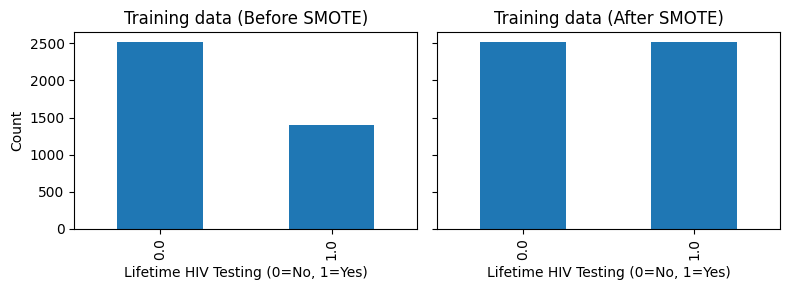

In [17]:
# ==== SMOTE on TRAIN ONLY for all-categorical predictors ====
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# 1) Train/test split (test stays untouched by SMOTE)
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.20, random_state=42, stratify=y
)

print("Class balance (full):")
print(y.value_counts(), "\n")
print("Train before SMOTE:")
print(y_train.value_counts())
print("\nTest (never resampled):")
print(y_test.value_counts())

# 2) Preprocess: impute most-frequent + one-hot for ALL columns (all are categorical)
preprocess_cat = ColumnTransformer(
    transformers=[
        ("cat",
         Pipeline(steps=[
             ("impute", SimpleImputer(strategy="most_frequent")),
             # FIX: use sparse_output=False (new sklearn >=1.2)
             ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
         ]),
         x.columns.tolist()
        )
    ],
    remainder="drop"
)

# 3) Build pipeline: transform -> SMOTE   (no classifier yet)
smote_pipe = ImbPipeline(steps=[
    ("prep", preprocess_cat),
    ("smote", SMOTE(random_state=42))
])

# 4) Fit-resample on TRAINING ONLY
X_resampled, y_resampled = smote_pipe.fit_resample(X_train, y_train)

print("\nTrain after SMOTE:")
print(y_resampled.value_counts())

# 5) Quick bar plots for train counts before/after
fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
y_train.value_counts().sort_index().plot(kind="bar", ax=axes[0], title="Training data (Before SMOTE)")
y_resampled.value_counts().sort_index().plot(kind="bar", ax=axes[1], title="Training data (After SMOTE)")
for ax in axes:
    ax.set_xlabel("Lifetime HIV Testing (0=No, 1=Yes)")
    ax.set_ylabel("Count")
plt.tight_layout()
plt.show()

**Cross-validation For the Analysis**

In [18]:
# ==== Cross-validation setup (before model building) ====
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
import numpy as np

# Preprocess (all predictors are categorical)
preprocess_cat = ColumnTransformer(
    transformers=[
        ("cat",
         Pipeline(steps=[
             ("impute", SimpleImputer(strategy="most_frequent")),
             ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
         ]),
         x.columns.tolist()
        )
    ],
    remainder="drop"
)

# Model
rf = RandomForestClassifier(n_estimators=400, random_state=42, n_jobs=-1, class_weight="balanced")

# Pipeline: preprocess -> SMOTE (train folds only) -> model
rf_pipe = ImbPipeline(steps=[
    ("prep", preprocess_cat),
    ("smote", SMOTE(random_state=42)),
    ("clf", rf)
])

# Stratified CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_pipe, X_train, y_train, cv=skf, scoring='accuracy', n_jobs=-1)

print(f"CV accuracies: {np.round(cv_scores, 4)}")
print(f"Mean accuracy: {cv_scores.mean():.4f}")
print(f"SD: {cv_scores.std():.4f}")


CV accuracies: [0.6794 0.7163 0.7061 0.693  0.7134]
Mean accuracy: 0.7016
SD: 0.0137


**Model Building and Evaluation as well as Recursive Feature Elimination (RFE)**

In [19]:
# ==== Build & evaluate models with SMOTE + RFE nested inside 5-fold CV, then test on hold-out set ====

from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.feature_selection import RFE
from sklearn.model_selection import StratifiedKFold, GridSearchCV

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, balanced_accuracy_score,
    classification_report, confusion_matrix
)

import numpy as np
import pandas as pd

RANDOM_STATE = 42

# -----------------------------
# 1) Preprocess: all predictors categorical
# -----------------------------
preprocess_cat = ColumnTransformer(
    transformers=[
        ("cat",
         Pipeline(steps=[
             ("impute", SimpleImputer(strategy="most_frequent")),
             ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))  # sklearn ≥1.2
         ]),
         X_train.columns.tolist()  # <-- use X_train columns
        )
    ],
    remainder="drop"
)

# -----------------------------
# 2) RFE selector (inside CV)
#    Use LR as the feature-ranking estimator so it works for any downstream model
# -----------------------------
rfe_ranker = LogisticRegression(
    max_iter=3000,
    solver="liblinear",   # stable for smaller/medium OHE matrices
    random_state=RANDOM_STATE
)

# RFE itself (n_features_to_select will be tuned in CV)
rfe = RFE(
    estimator=rfe_ranker,
    n_features_to_select=50,  # placeholder; tuned by GridSearchCV
    step=0.1                  # drop 10% each iteration (faster than step=1)
)

def make_pipe(est):
    # All steps happen inside CV folds when used in GridSearchCV
    return ImbPipeline(steps=[
        ("prep", preprocess_cat),
        ("smote", SMOTE(random_state=RANDOM_STATE)),
        ("rfe", rfe),
        ("clf", est)
    ])

# -----------------------------
# 3) Models + tuning grids
#    (Keep grids modest; expand if you want deeper tuning)
# -----------------------------
models_and_grids = {
    "LR": (
        LogisticRegression(max_iter=3000, solver="lbfgs"),
        {
            "rfe__n_features_to_select": [30, 50, 80, 120],
            "clf__C": [0.1, 1.0, 10.0]
        }
    ),
    "NB": (
        BernoulliNB(),
        {
            "rfe__n_features_to_select": [30, 50, 80, 120],
            "clf__alpha": [0.1, 1.0, 2.0]
        }
    ),
    "SVM": (
        SVC(kernel="rbf", probability=True, gamma="scale", random_state=RANDOM_STATE),
        {
            "rfe__n_features_to_select": [30, 50, 80, 120],
            "clf__C": [0.5, 1.0, 2.0]
        }
    ),
    "KNN": (
        KNeighborsClassifier(),
        {
            "rfe__n_features_to_select": [30, 50, 80, 120],
            "clf__n_neighbors": [5, 15, 25]
        }
    ),
    "DT": (
        DecisionTreeClassifier(random_state=RANDOM_STATE),
        {
            "rfe__n_features_to_select": [30, 50, 80, 120],
            "clf__max_depth": [None, 5, 10],
            "clf__min_samples_leaf": [1, 2, 5]
        }
    ),
    "RF": (
        RandomForestClassifier(n_estimators=400, n_jobs=-1, random_state=RANDOM_STATE),
        {
            "rfe__n_features_to_select": [30, 50, 80, 120],
            "clf__max_depth": [None, 10, 20],
            "clf__min_samples_leaf": [1, 2, 5]
        }
    ),
    "GB": (
        GradientBoostingClassifier(random_state=RANDOM_STATE),
        {
            "rfe__n_features_to_select": [30, 50, 80, 120],
            "clf__learning_rate": [0.05, 0.1],
            "clf__n_estimators": [100, 300]
        }
    ),
    "XGB": (
        XGBClassifier(
            eval_metric="auc",
            tree_method="hist",
            random_state=RANDOM_STATE
        ),
        {
            "rfe__n_features_to_select": [30, 50, 80, 120],
            "clf__n_estimators": [200, 600],
            "clf__max_depth": [3, 4],
            "clf__learning_rate": [0.05, 0.1],
            "clf__subsample": [0.8, 0.9],
            "clf__colsample_bytree": [0.8, 0.9]
        }
    )
}

# -----------------------------
# 4) CV setup (training only)
# -----------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

rows = []
fitted = {}
best_params_store = {}

for name, (est, param_grid) in models_and_grids.items():
    pipe = make_pipe(est)

    # Grid search: RFE + model tuning happens INSIDE CV folds
    gs = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring="roc_auc",
        cv=cv,
        n_jobs=-1,
        refit=True
    )

    gs.fit(X_train, y_train)   # trains only on training data (with internal CV)
    best_model = gs.best_estimator_
    fitted[name] = best_model
    best_params_store[name] = gs.best_params_

    # ---- Test-set evaluation (untouched test set) ----
    if hasattr(best_model, "predict_proba"):
        proba = best_model.predict_proba(X_test)[:, 1]
    elif hasattr(best_model, "decision_function"):
        scores = best_model.decision_function(X_test)
        proba = 1 / (1 + np.exp(-scores))
    else:
        proba = None

    pred = best_model.predict(X_test)

    row = {
        "Model": name,
        "CV_best_AUROC": gs.best_score_,
        "Accuracy": accuracy_score(y_test, pred),
        "Precision": precision_score(y_test, pred, zero_division=0),
        "Recall": recall_score(y_test, pred, zero_division=0),
        "F1": f1_score(y_test, pred, zero_division=0),
        "BalancedAcc": balanced_accuracy_score(y_test, pred)
    }

    if proba is not None:
        row.update({
            "AUROC": roc_auc_score(y_test, proba),
            "PR-AUC": average_precision_score(y_test, proba)
        })
    else:
        row.update({"AUROC": np.nan, "PR-AUC": np.nan})

    rows.append(row)

results_df = pd.DataFrame(rows).sort_values("AUROC", ascending=False)

print("\nHold-out Test Performance (unresampled test set; RFE+SMOTE+tuning nested within CV on training only):")
display(results_df.round(3))

print("\nBest parameters selected by CV (includes RFE feature count):")
for k, v in best_params_store.items():
    print(f"{k}: {v}")

# -----------------------------
# 5) Detailed report for best test-set model
# -----------------------------
best_name = results_df.iloc[0]["Model"]
best = fitted[best_name]
best_pred = best.predict(X_test)

print(f"\n=== Detailed report for best model on hold-out test set: {best_name} ===")
print(classification_report(y_test, best_pred, digits=3))
print("Confusion matrix:\n", confusion_matrix(y_test, best_pred))


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=80 > n_features=67. There will be no feature selection and all features will be kept.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=80 > n_features=67. There will be no feature selection and all features will be kept.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=80 > n_features=67. There will be no feature selection and all features will be kept.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=80 > n_features=67. There will be no feature selection and all features will be kept.
  warnings.warn(



Hold-out Test Performance (unresampled test set; RFE+SMOTE+tuning nested within CV on training only):


,Model,CV_best_AUROC,Accuracy,Precision,Recall,F1,BalancedAcc,AUROC,PR-AUC
7,XGB,0.735,0.694,0.595,0.447,0.511,0.639,0.718,0.583
0,LR,0.729,0.647,0.504,0.664,0.573,0.651,0.716,0.585
6,GB,0.735,0.687,0.573,0.481,0.523,0.641,0.715,0.574
2,SVM,0.723,0.685,0.556,0.575,0.566,0.660,0.713,0.576
5,RF,0.735,0.692,0.578,0.507,0.540,0.651,0.713,0.571
1,NB,0.712,0.647,0.505,0.601,0.549,0.637,0.688,0.532
4,DT,0.693,0.694,0.601,0.425,0.497,0.634,0.686,0.520
3,KNN,0.699,0.614,0.470,0.624,0.536,0.617,0.669,0.501



Best parameters selected by CV (includes RFE feature count):
LR: {'clf__C': 0.1, 'rfe__n_features_to_select': 80}
NB: {'clf__alpha': 2.0, 'rfe__n_features_to_select': 80}
SVM: {'clf__C': 0.5, 'rfe__n_features_to_select': 50}
KNN: {'clf__n_neighbors': 25, 'rfe__n_features_to_select': 30}
DT: {'clf__max_depth': 5, 'clf__min_samples_leaf': 5, 'rfe__n_features_to_select': 30}
RF: {'clf__max_depth': 10, 'clf__min_samples_leaf': 5, 'rfe__n_features_to_select': 50}
GB: {'clf__learning_rate': 0.05, 'clf__n_estimators': 100, 'rfe__n_features_to_select': 80}
XGB: {'clf__colsample_bytree': 0.8, 'clf__learning_rate': 0.05, 'clf__max_depth': 3, 'clf__n_estimators': 200, 'clf__subsample': 0.9, 'rfe__n_features_to_select': 80}

=== Detailed report for best model on hold-out test set: XGB ===
              precision    recall  f1-score   support

         0.0      0.730     0.831     0.777       632
         1.0      0.595     0.447     0.511       351

    accuracy                          0.694    

**For Extreme Gradient Boosting Model**

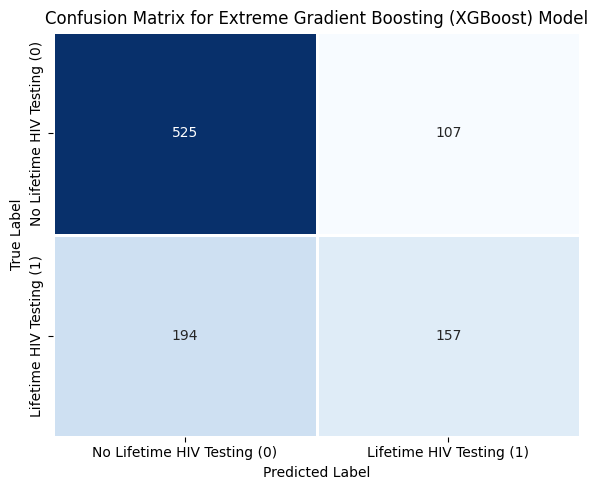


Specificity (True Negative Rate): 0.831
Sensitivity (True Positive Rate): 0.447


In [20]:
# ==== Confusion Matrix for the Best Model (Extreme Gradient Boosting (XGB) Model) ====

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict class labels using the best model (XGB)
y_pred_best = (best.predict_proba(X_test)[:, 1] >= 0.5).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_best)

labels = ["No Lifetime HIV Testing (0)", "Lifetime HIV Testing (1)"]

# Heatmap visualization
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=labels, yticklabels=labels,
    cbar=False, linewidths=1
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Extreme Gradient Boosting (XGBoost) Model")
plt.tight_layout()
plt.show()

# Optional: Class-wise performance rates
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0

print(f"\nSpecificity (True Negative Rate): {specificity:.3f}")
print(f"Sensitivity (True Positive Rate): {sensitivity:.3f}")

**The Area Under the Receiver Operating Characteristic (AUROC)**

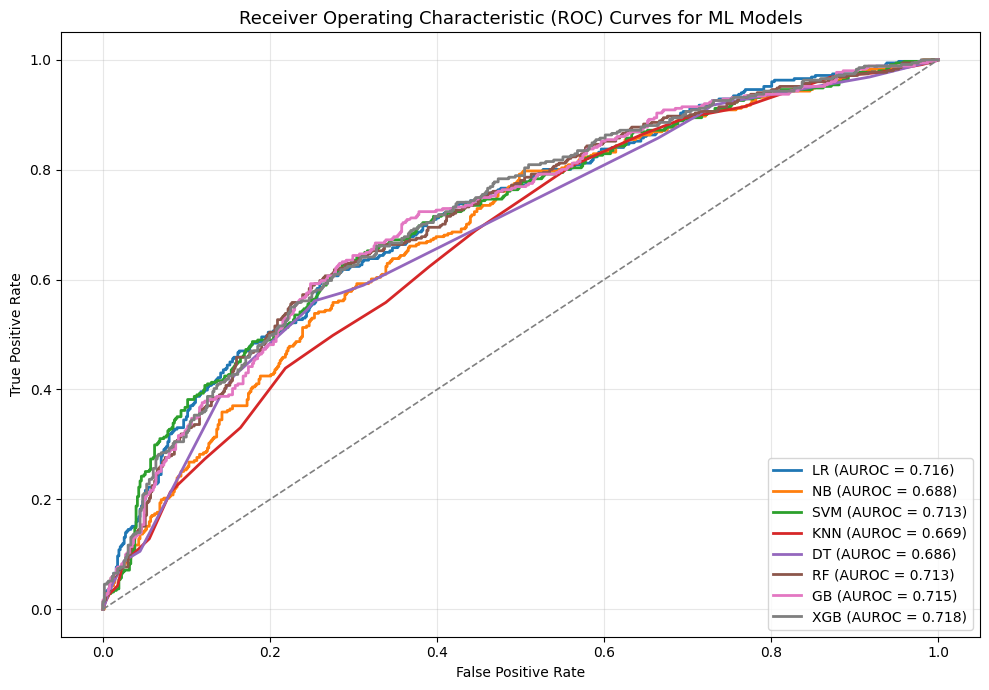

In [21]:
# ==== ROC Curves for All Models ====
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 7))

# Use the fitted dictionary of trained pipelines from your previous step
for name, model in fitted.items():
    # Predict probabilities for positive class
    y_score = model.predict_proba(X_test)[:, 1]

    # Compute ROC curve and area under curve
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUROC = {roc_auc:.3f})')

# Add chance line
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', lw=1.2)

# Styling
plt.title('Receiver Operating Characteristic (ROC) Curves for ML Models', fontsize=13)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right', frameon=True)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


**The Area Under the Precision Recall (PR) Curve (PR-AUC)**

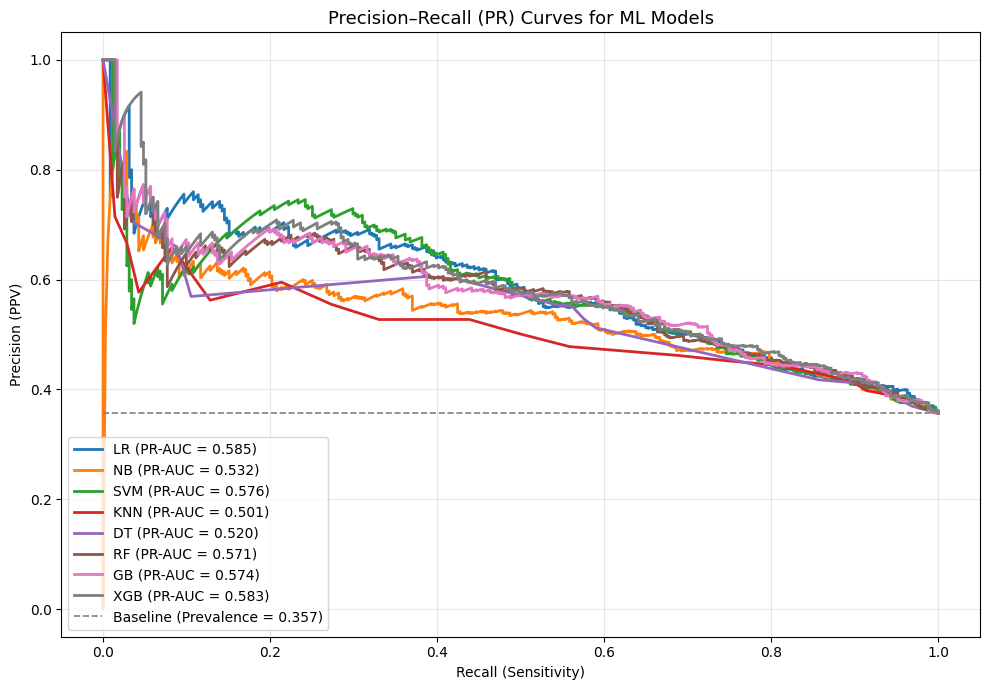

In [32]:
# ==== Precision–Recall (PR) Curves for All Models ====
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 7))

# Loop through fitted models
for name, model in fitted.items():
    # Predict probabilities for positive class
    y_score = model.predict_proba(X_test)[:, 1]

    # Compute Precision–Recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_score)

    # Compute PR-AUC (Average Precision)
    pr_auc = average_precision_score(y_test, y_score)

    # Plot PR curve
    plt.plot(
        recall,
        precision,
        lw=2,
        label=f'{name} (PR-AUC = {pr_auc:.3f})'
    )

# Baseline (prevalence of positive class)
baseline = np.mean(y_test)
plt.hlines(
    y=baseline,
    xmin=0,
    xmax=1,
    colors='grey',
    linestyles='--',
    lw=1.2,
    label=f'Baseline (Prevalence = {baseline:.3f})'
)

# Styling
plt.title('Precision–Recall (PR) Curves for ML Models', fontsize=13)
plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision (PPV)')
plt.legend(loc='lower left', frameon=True)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


**Grouped bar chart of model metrics (incl. BalancedAcc, PR-AUC)**

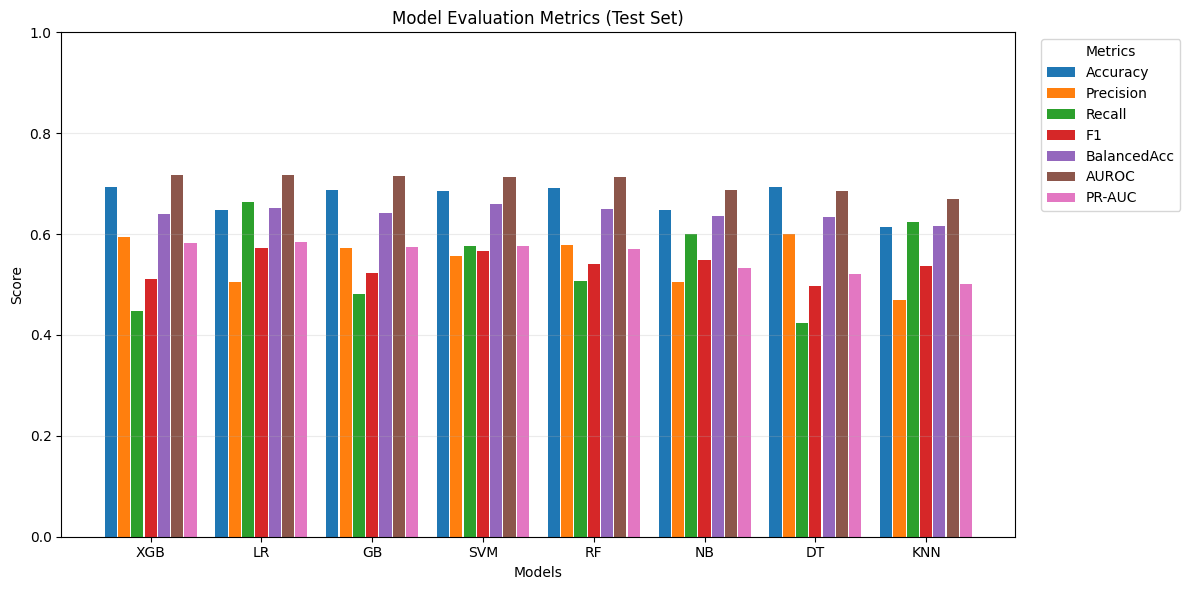

In [22]:
# ==== Grouped bar chart of model metrics (incl. BalancedAcc, PR-AUC) ====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# If you already have results_df from earlier, use it; otherwise build it from your lists.
# results_df should have columns: Model, Accuracy, Precision, Recall, F1, BalancedAcc, AUROC, PR-AUC
metrics_to_plot = ["Accuracy", "Precision", "Recall", "F1", "BalancedAcc", "AUROC", "PR-AUC"]

plot_df = results_df.set_index("Model")[metrics_to_plot].copy()
model_names = plot_df.index.tolist()
M = len(model_names)
K = len(metrics_to_plot)

# Bar positions
x = np.arange(M)
bar_w = 0.11
offsets = (np.arange(K) - (K-1)/2) * (bar_w + 0.01)

plt.figure(figsize=(12, 6))
for i, metric in enumerate(metrics_to_plot):
    plt.bar(x + offsets[i], plot_df[metric].values, width=bar_w, label=metric)

# Labels & styling
plt.xticks(x, model_names, rotation=0, fontsize=10)
plt.ylim(0, 1.0)
plt.xlabel("Models")
plt.ylabel("Score")
plt.title("Model Evaluation Metrics (Test Set)")
plt.legend(title="Metrics", loc="upper left", bbox_to_anchor=(1.02, 1))
plt.grid(axis="y", alpha=0.25)
plt.tight_layout()
plt.show()


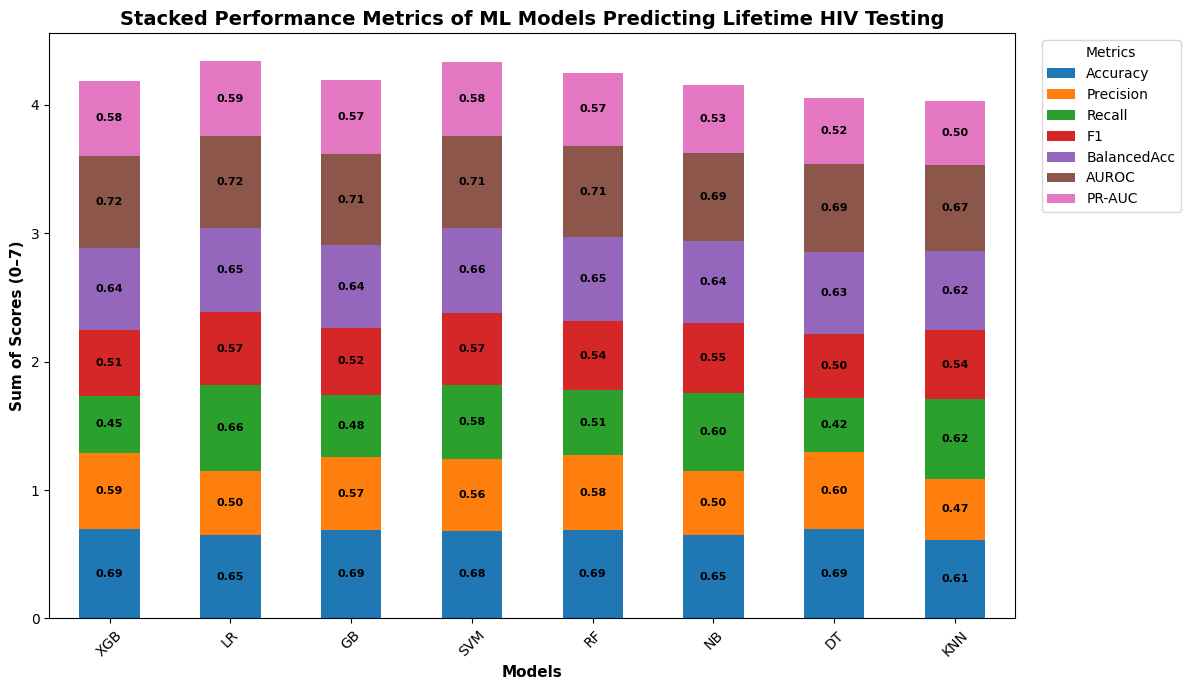

In [23]:
# ==== Stacked Bar Chart for EverHIV Testing Model Performance ====

import matplotlib.pyplot as plt

# Select metrics from your results_df
stack_df = results_df.set_index("Model")[
    ["Accuracy", "Precision", "Recall", "F1", "BalancedAcc", "AUROC", "PR-AUC"]
].copy()

fig, ax = plt.subplots(figsize=(12, 7))

# Generate stacked bar chart
stack_df.plot(kind="bar", stacked=True, ax=ax)

# Titles and axis labels
plt.title("Stacked Performance Metrics of ML Models Predicting Lifetime HIV Testing",
          fontsize=14, fontweight="bold")
plt.xlabel("Models", fontsize=11, fontweight="bold")
plt.ylabel("Sum of Scores (0–7)", fontsize=11, fontweight="bold")
plt.xticks(rotation=45)

# Legend placement
plt.legend(title="Metrics", bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()

# === Add metric values inside each stacked segment ===
for container in ax.containers:
    ax.bar_label(
        container,
        fmt="%.2f",
        label_type="center",
        fontsize=8,
        color="black",
        fontweight="bold"
    )

plt.show()

**Confusion Matrix of all Models**

In [24]:
from sklearn.metrics import confusion_matrix
import pandas as pd

# Initialize list for results
conf_list = []

# Loop through all trained models
for name, model in fitted.items():
    # Predict on test data
    y_pred = (model.predict_proba(X_test)[:, 1] >= 0.5).astype(int)

    # Compute confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    conf_list.append({
        "Model": name,
        "TP": tp,
        "FP": fp,
        "FN": fn,
        "TN": tn
    })

# Convert to DataFrame
conf_df = pd.DataFrame(conf_list)

# Order the models in the same order as before (optional)
model_order = ["LR", "SVM", "KNN", "DT", "NB", "RF", "GB", "XGB"]
conf_df = conf_df.set_index("Model").loc[model_order].reset_index()

# Display the table
print("\nConfusion Matrix Counts (Test Set)")
display(conf_df)



Confusion Matrix Counts (Test Set)


,Model,TP,FP,FN,TN
0,LR,233,229,118,403
1,SVM,207,167,144,465
2,KNN,219,247,132,385
3,DT,149,99,202,533
4,NB,211,207,140,425
5,RF,178,130,173,502
6,GB,169,126,182,506
7,XGB,157,107,194,525


**SHapley Additive exPlanations (SHAP) For Extreme Gradient Boosting (XGBoost)**

**Extreme Gradient Boosting Model & SHAP Analysis**

Top variables by aggregated mean |SHAP| values (XGB Depression model):


,base,mean_abs_shap
0,age_group,0.728510
18,smoking_status,0.239837
20,veteran_status,0.198247
15,race_ethnicity,0.197228
12,ment_health_days,0.163436
11,marital_status,0.153257
10,income_group,0.116301
5,education_level,0.115432
14,phys_health_days,0.095060
17,sex,0.093797


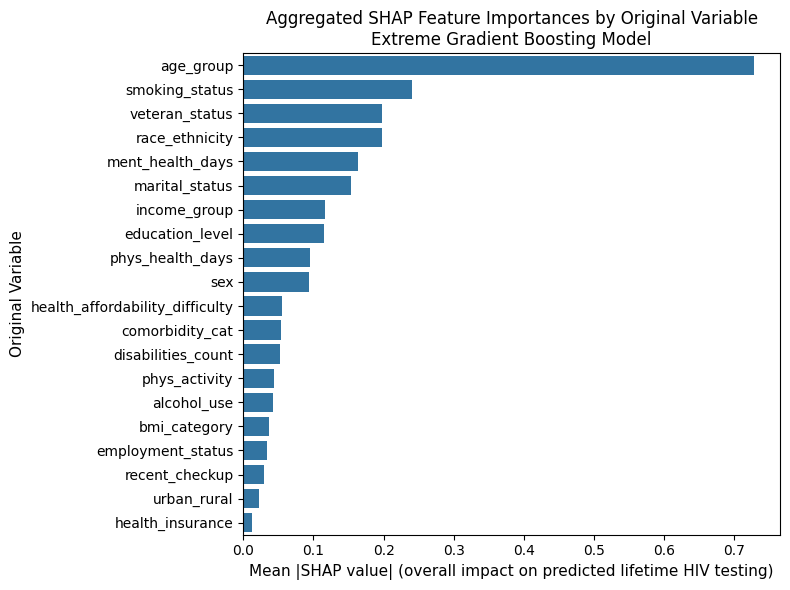


Number of original variables (groups): 21


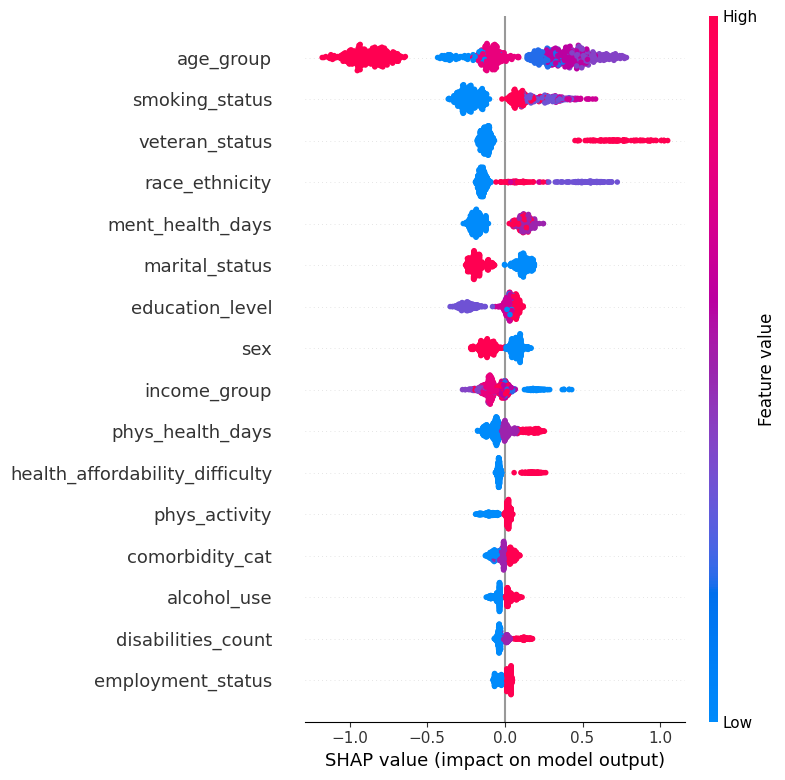

In [29]:
# ==== Aggregated SHAP Feature Importance + Grouped Beeswarm for XGB (Lifetime HIV Testing model) ====
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# -------------------------------------------------------------------
# 0) Pull GB pipeline and build SHAP explainer
# -------------------------------------------------------------------
# Assumes:
#   fitted["XGB"] -> trained XGB pipeline (prep + smote + clf)
#   X_test       -> original test DataFrame (same columns used in training)
#   y_test       -> binary outcome (0/1)

# --- 0) Pull fitted XGB pipeline ---
xgb_pipe = fitted["XGB"]
prep = xgb_pipe.named_steps["prep"]   # ColumnTransformer (impute + OHE)
clf  = xgb_pipe.named_steps["clf"]    # XGBClassifier

# Transform X_test (no SMOTE at inference)
X_test_tx = prep.transform(X_test)

# Get original feature names used by the transformer (works even if you didn't define `predictors`)
feature_cols = prep.feature_names_in_.tolist() if hasattr(prep, "feature_names_in_") else X_test.columns.tolist()

# Get post-encoding feature names
oh = prep.named_transformers_["cat"].named_steps["onehot"]
feat_names = list(oh.get_feature_names_out(input_features=feature_cols))

# TreeExplainer for GB
explainer = shap.TreeExplainer(clf)
shap_vals = explainer.shap_values(X_test_tx)

# Handle binary output shapes across SHAP versions
# - Sometimes returns (n_samples, n_features)
# - Sometimes returns list [class0, class1]
# - Sometimes returns (n_samples, n_features, n_classes)
if isinstance(shap_vals, list):
    shap_vals_pos = shap_vals[1]
elif getattr(shap_vals, "ndim", 0) == 3:
    shap_vals_pos = shap_vals[:, :, 1]
else:
    shap_vals_pos = shap_vals

# -------------------------------------------------------------------
# 1) Aggregate SHAP values by original variable (post-OHE groups)
# -------------------------------------------------------------------
def base_var(name: str) -> str:
    """
    Convert one-hot feature names like:
      'race_ethnicity_5cat_3' or 'sex_1'
    back to the original variable name.

    This is robust to underscores in the original variable name.
    """
    # SHAP/Sklearn OHE uses pattern: "<original>_<category>"
    # We strip the last "_<category>" chunk.
    if "_" in name:
        return name.rsplit("_", 1)[0]
    return name

mean_abs = np.mean(np.abs(shap_vals_pos), axis=0)

agg = (
    pd.DataFrame({"feature": feat_names, "mean_abs_shap": mean_abs})
      .assign(base=lambda d: d["feature"].map(base_var))
      .groupby("base", as_index=False)["mean_abs_shap"].sum()
      .sort_values("mean_abs_shap", ascending=False)
)

print("Top variables by aggregated mean |SHAP| values (XGB Depression model):")
display(agg.head(21))

# -------------------------------------------------------------------
# 2) Bar plot of aggregated SHAP importances (original variables)
# -------------------------------------------------------------------
plt.figure(figsize=(8, 6))
sns.barplot(
    data=agg.head(20),
    x="mean_abs_shap",
    y="base"
)
plt.title(
    "Aggregated SHAP Feature Importances by Original Variable\nExtreme Gradient Boosting Model",
)
plt.xlabel("Mean |SHAP value| (overall impact on predicted lifetime HIV testing)", fontsize=11)
plt.ylabel("Original Variable", fontsize=11)
plt.tight_layout()
plt.show()

# -------------------------------------------------------------------
# 3) Grouped SHAP beeswarm at original-variable level
# -------------------------------------------------------------------
# Build mapping from encoded features -> base variable
groups = {}
for idx, fname in enumerate(feat_names):
    b = base_var(fname)
    groups.setdefault(b, []).append(idx)

base_vars = list(groups.keys())
print(f"\nNumber of original variables (groups): {len(base_vars)}")

# Build grouped SHAP matrix: sum SHAP over one-hot columns for each original variable
n_samples = shap_vals_pos.shape[0]
shap_grouped = np.zeros((n_samples, len(base_vars)))

for j, b in enumerate(base_vars):
    cols = groups[b]
    shap_grouped[:, j] = shap_vals_pos[:, cols].sum(axis=1)

# Build a matching X matrix (original variables) for coloring in beeswarm
# (convert categories -> integer codes)
X_grouped = X_test[base_vars].copy()
for col in X_grouped.columns:
    X_grouped[col] = X_grouped[col].astype("category").cat.codes

# Beeswarm plot at original-variable level
shap.summary_plot(
    shap_grouped,
    X_grouped.values,
    feature_names=base_vars,
    max_display=16,
    show=True
)

**SHAP Waterfall Plot**

Index 0 predicted P(Ever HIV tested=1): 0.676


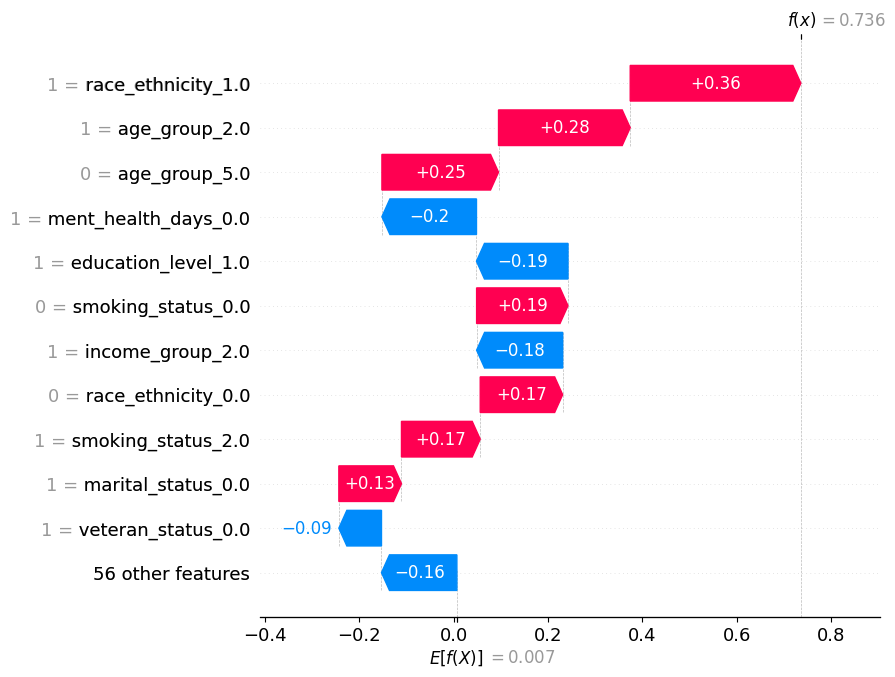

In [28]:
# ============================================================
# 4) Individual prediction explanation (SHAP Waterfall)
#    A) Encoded-feature level (post-OHE; most faithful)
# ============================================================

# Pick which individual in X_test to explain
i = 0  # change this (e.g., i=10) to explain a different person

# ---- Build SHAP Explanation object (robust across SHAP versions) ----
# Get expected/base value (binary can be scalar or 2-length)
base_val = explainer.expected_value
if isinstance(base_val, (list, np.ndarray)) and len(np.atleast_1d(base_val)) > 1:
    base_val_pos = base_val[1]
else:
    base_val_pos = float(np.ravel(base_val)[0])

# Get the individual SHAP vector (positive class)
sv_i = shap_vals_pos[i, :]  # (n_features,)

# Get the individual feature vector (transformed)
x_i = X_test_tx[i, :]
# If sparse matrix, convert to dense row vector for plotting
try:
    x_i_dense = x_i.toarray().ravel()
except Exception:
    x_i_dense = np.array(x_i).ravel()

# Create Explanation for waterfall
exp_i = shap.Explanation(
    values=sv_i,
    base_values=base_val_pos,
    data=x_i_dense,
    feature_names=feat_names
)

# Optional: show model probability for context
proba_i = xgb_pipe.predict_proba(X_test.iloc[[i]])[:, 1][0]
print(f"Index {i} predicted P(Ever HIV tested=1): {proba_i:.3f}")

# Waterfall (encoded features)
shap.plots.waterfall(exp_i, max_display=12)

**LIME (Local Interpretable Model-agnostic Explanations)**

Intercept 0.5190517724206044
Prediction_local [0.6821422]
Right: 0.6760999
Index 0 predicted P(Ever HIV tested=1): 0.676


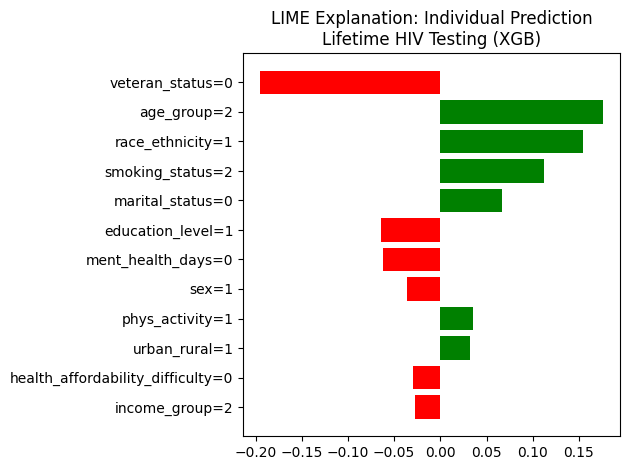

In [33]:
# ============================================================
# 5) Individual prediction explanation using LIME (XGB)
# ============================================================

# 1) Import LIME Tabular Explainer
!pip install lime
from lime import lime_tabular

# ------------------------------------------------------------
# 2) Prepare training data for LIME (MUST be numpy, pre-OHE)
#    LIME learns local perturbations in original feature space
# ------------------------------------------------------------

X_train_np = X_train.values
X_test_np  = X_test.values

feature_names = X_train.columns.tolist()

# Identify categorical feature indices (important for BRFSS)
cat_features = [
    X_train.columns.get_loc(c)
    for c in prep.named_transformers_["cat"].feature_names_in_
]

# ------------------------------------------------------------
# 3) Define prediction function (pipeline-safe)
# ------------------------------------------------------------
def predict_proba_lime(X):
    """
    LIME passes a numpy array of original features.
    We convert to DataFrame, then use the FULL pipeline.
    """
    X_df = pd.DataFrame(X, columns=feature_names)
    return xgb_pipe.predict_proba(X_df)

# ------------------------------------------------------------
# 4) Build LIME explainer
# ------------------------------------------------------------
lime_explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_train_np,
    feature_names=feature_names,
    class_names=["No", "Yes"],  # Ever HIV tested
    categorical_features=cat_features,
    discretize_continuous=True,
    mode="classification",
    verbose=True,
    random_state=42
)

# ------------------------------------------------------------
# 5) Explain an individual prediction
# ------------------------------------------------------------
i = 0  # index of individual to explain

exp = lime_explainer.explain_instance(
    data_row=X_test_np[i],
    predict_fn=predict_proba_lime,
    num_features=12
)

# Print predicted probability for context
proba_i = xgb_pipe.predict_proba(X_test.iloc[[i]])[:, 1][0]
print(f"Index {i} predicted P(Ever HIV tested=1): {proba_i:.3f}")

# ------------------------------------------------------------
# 6) Visualize explanation (LIME bar plot)
# ------------------------------------------------------------
fig = exp.as_pyplot_figure()
plt.title("LIME Explanation: Individual Prediction\nLifetime HIV Testing (XGB)")
plt.tight_layout()
plt.show()